In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import os
from datetime import date
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import itertools
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn import metrics

In [3]:
# This snippet assumes you run setup first

# This code copies file in your Google Bucket and loads it into a dataframe


Covid_Q_filename = 'Covid_Q.csv'
Overall_Health_Q_filename = 'Overall_Health_Q.csv'
Personal_Medical_History_Q_filename = 'Personal_Medical_History_Q.csv'
Lifestyle_Q_filename = 'Lifestyle_Q.csv'
The_Basics_Q_filename = 'The_Basics_Q.csv'
Health_Care_Access_Utilization_Q_filename = 'Health_Care_Access_Utilization_Q.csv'
Demographic_Q_filename = 'Demographic_Q.csv'

all_datasets = [Covid_Q_filename,Overall_Health_Q_filename,Personal_Medical_History_Q_filename,Lifestyle_Q_filename,
               The_Basics_Q_filename,Health_Care_Access_Utilization_Q_filename,Demographic_Q_filename]
########################################################################
##
################# DON'T CHANGE FROM HERE ###############################
##
########################################################################

# get the bucket name
my_bucket = os.getenv('WORKSPACE_BUCKET')

# copy csv file from the bucket to the current working space

for dataset_name in all_datasets:
    os.system(f"gsutil cp '{my_bucket}/data/{dataset_name}' .")
    print(f'[INFO] {dataset_name} is successfully downloaded into your working space')


# save dataframe in a csv file in the same workspace as the notebook
Covid_Q = pd.read_csv('Covid_Q.csv')
Overall_Health_Q = pd.read_csv('Overall_Health_Q.csv')
Personal_Medical_History_Q = pd.read_csv('Personal_Medical_History_Q.csv')
Lifestyle_Q = pd.read_csv('Lifestyle_Q.csv')
The_Basics_Q = pd.read_csv('The_Basics_Q.csv')
Health_Care_Access_Utilization_Q = pd.read_csv('Health_Care_Access_Utilization_Q.csv')
Demographic_Q = pd.read_csv('Demographic_Q.csv')


Copying gs://fc-secure-b41a20d8-cc27-4b00-94b8-ccd4711ca733/data/Covid_Q.csv...
\ [1 files][  4.6 GiB/  4.6 GiB]   48.1 MiB/s                                   
Operation completed over 1 objects/4.6 GiB.                                      


[INFO] Covid_Q.csv is successfully downloaded into your working space


Copying gs://fc-secure-b41a20d8-cc27-4b00-94b8-ccd4711ca733/data/Overall_Health_Q.csv...
/ [1 files][332.6 MiB/332.6 MiB]                                                
Operation completed over 1 objects/332.6 MiB.                                    


[INFO] Overall_Health_Q.csv is successfully downloaded into your working space


Copying gs://fc-secure-b41a20d8-cc27-4b00-94b8-ccd4711ca733/data/Personal_Medical_History_Q.csv...
/ [1 files][862.4 MiB/862.4 MiB]   45.3 MiB/s                                   
Operation completed over 1 objects/862.4 MiB.                                    


[INFO] Personal_Medical_History_Q.csv is successfully downloaded into your working space


Copying gs://fc-secure-b41a20d8-cc27-4b00-94b8-ccd4711ca733/data/Lifestyle_Q.csv...
\ [1 files][255.4 MiB/255.4 MiB]                                                
Operation completed over 1 objects/255.4 MiB.                                    


[INFO] Lifestyle_Q.csv is successfully downloaded into your working space


Copying gs://fc-secure-b41a20d8-cc27-4b00-94b8-ccd4711ca733/data/The_Basics_Q.csv...
/ [1 files][322.2 MiB/322.2 MiB]                                                
Operation completed over 1 objects/322.2 MiB.                                    


[INFO] The_Basics_Q.csv is successfully downloaded into your working space


Copying gs://fc-secure-b41a20d8-cc27-4b00-94b8-ccd4711ca733/data/Health_Care_Access_Utilization_Q.csv...
/ [1 files][  134.0 B/  134.0 B]                                                
Operation completed over 1 objects/134.0 B.                                      


[INFO] Health_Care_Access_Utilization_Q.csv is successfully downloaded into your working space


Copying gs://fc-secure-b41a20d8-cc27-4b00-94b8-ccd4711ca733/data/Demographic_Q.csv...
/ [1 files][ 15.9 MiB/ 15.9 MiB]                                                
Operation completed over 1 objects/15.9 MiB.                                     


[INFO] Demographic_Q.csv is successfully downloaded into your working space


In [4]:
# The questions we want to look at in our Final Project Proposal
hesitancy = ['When a COVID-19 vaccine is available, how likely are you to want to receive vaccination?']
death = ['Do you personally know someone who has died of COVID-19?']
adverse_exp = ['In the past month, have you experienced the following as a result of COVID-19? Select all that apply.',
              'In the past month, have the following behaviors increased in your household? Select all that apply.']
social_dist = ['Choose the answer that is true for you in the past month. I am unhappy being so withdrawn.', 
               'In the past month, have recommendations for socially distancing caused stress for you?']
social_habits = ['Thinking about these activities in the last 5 days, my social interaction with people outside my home was.',
                'Choose the answer that is true for you in the past month. I lack companionship.',
                'Choose the answer that is true for you in the past month. I can find companionship when I want it.']

# Putting all these questions in a single list so we can single them out
all_Q = itertools.chain(hesitancy,death,adverse_exp,social_dist,social_habits)
all_Q = list(all_Q)

In [5]:
# All the questions in all_Q are from the COPE survey, so they must be contained in Covid_Q
# covid_df keep only the questions from the whole COPE survey that are the ones we want (all_Q)
covid_df = Covid_Q[np.isin(Covid_Q['question'], all_Q)]

# Let's keep only these variables
covid_simplified = covid_df[['answer','question','person_id','survey_datetime']]

# The hesitancy question, AKA the label for our dataset
covid_label = covid_simplified[covid_simplified['question'] == hesitancy[0]]

# Other covid-related questions
covid_q1 = covid_simplified[covid_simplified['question'] == death[0]]
covid_q2 = covid_simplified[covid_simplified['question'] == adverse_exp[0]]
covid_q3 = covid_simplified[covid_simplified['question'] == adverse_exp[1]]
covid_q4 = covid_simplified[covid_simplified['question'] == social_dist[0]]
covid_q5 = covid_simplified[covid_simplified['question'] == social_dist[1]]
covid_q6 = covid_simplified[covid_simplified['question'] == social_habits[0]]
covid_q7 = covid_simplified[covid_simplified['question'] == social_habits[1]]
covid_q8 = covid_simplified[covid_simplified['question'] == social_habits[2]]

In [6]:
# For Q1, the death question, a binary response
def Binarize(binary_response): 
    if binary_response == 'PMI: Skip':
        return np.nan
    else: # returns 1 if binary_response = 'Yes', and returns 0 if 'No'
        return (binary_response == 'Yes')
    
# For Q2, kinda complicated since they can pick multiple answers
def Pick_All_That_Apply_Q2(df):
    # A dictionary that shows which indices in the df have a certain response
    # e.g. {'Did not have a regular place to sleep or stay' : 1,2,4,6,7,8,11...}
    grouped_dict = df.groupby('answer').groups
    all_responses = []
    for index, row in df.iterrows():
        no_home_ans = index in grouped_dict['Did not have a regular place to sleep or stay']
        no_med_ans = index in grouped_dict['Did not have enough money to pay for medications']
        no_food_ans = index in grouped_dict['Not enough money to pay for food']
        no_gas_ans = index in grouped_dict['Not enough money to pay for gas']
        no_rent_ans = index in grouped_dict['Not enough money to pay rent']
        no_hardship_ans = index in grouped_dict['None of the above (if selected, no other response options are available']
        responses = [int(x) for x in [no_home_ans,no_med_ans,no_food_ans,no_gas_ans,no_rent_ans,no_hardship_ans]]
        all_responses.append(responses)
        
    col_names = ['no_home','no_meds','no_food','no_gas','no_rent','no_hardship']
    new_df = pd.DataFrame(all_responses,columns=col_names)
    new_df['person_id'] = df['person_id'].values
    new_df['survey_datetime'] = df['survey_datetime'].values
    
    # Because participants choose all that apply, there are basically multiple entries with the
    # same person_id and survey_datetime but different answers. This merges those rows by basically
    # adding them up (e.g. [1 0 0 0 0 0] + [0 0 1 0 0 0] = [1 0 1 0 0 0])
    new_df = new_df.groupby(['person_id','survey_datetime'],as_index=False).agg({'no_home': 'sum','no_meds': 'sum',
                                                                      'no_food': 'sum','no_gas': 'sum',
                                                                      'no_rent': 'sum','no_hardship': 'sum'})
    return new_df



# Just like Q2
def Pick_All_That_Apply_Q3(df):
    # A dictionary that shows which indices in the df have a certain response
    # e.g. {'Did not have a regular place to sleep or stay' : 1,2,4,6,7,8,11...}
    grouped_dict = df.groupby('answer').groups
    all_responses = []
    for index, row in df.iterrows():
        family_conflict_ans = index in grouped_dict['Interpersonal conflict with family members or loved ones']
        family_yelling_ans = index in grouped_dict['Snapping at or yelling at family members']
        friend_conflict_ans = index in grouped_dict['Interpersonal conflict with friends or coworkers']
        no_conflict_ans = index in grouped_dict['None of the above (if selected, no other response options are available']
        responses = [int(x) for x in [family_conflict_ans,family_yelling_ans,friend_conflict_ans,no_conflict_ans]]
        all_responses.append(responses)
        
    col_names = ['family_conflict','family_yelling','friend_conflict','no_conflict']
    new_df = pd.DataFrame(all_responses,columns=col_names)
    new_df['person_id'] = df['person_id'].values
    new_df['survey_datetime'] = df['survey_datetime'].values
    
    # Because participants choose all that apply, there are basically multiple entries with the
    # same person_id and survey_datetime but different answers. This merges those rows by basically
    # adding them up (e.g. [1 0 0 0] + [0 0 1 0] = [1 0 1 0])
    new_df = new_df.groupby(['person_id','survey_datetime'],as_index=False).agg({'family_conflict': 'sum',
                                                                                 'family_yelling': 'sum',
                                                                                 'friend_conflict': 'sum',
                                                                                 'no_conflict': 'sum'})
    return new_df

# For Q4,Q5,Q7,Q8, these are ordinal questions, so the values for each
# response are in the scoring_dict
def Four_Point_Ordinal(response):
    scoring_dict = {'PMI: Skip':np.nan,'Never':0,'Not at all':0,'Rarely':1,'A little':1,
                    'Sometimes':2,'Somewhat':2,'Often':3,'A lot':3}
    return scoring_dict[response]

# Q6, same as Q4,Q5,Q7,Q8, but it's a 5-point scale instead
def Five_Point_Ordinal(response):
    scoring_dict = {'PMI: Skip':np.nan,'A lot less than normal':0,'Somewhat less than normal':1,
                    'About the same as normal':3,'More than normal':4,'A lot more than normal':5}
    return scoring_dict[response]

# For vaccine hesitancy label
def Label_Encoder(label):
    label_dict = {'I do not know yet':0, 'PMI: Skip': 0,'Very unlikely':0, 'Unlikely':0,
                  'Likely':1, 'Very likely':1}
    return label_dict[label]

In [7]:
# Convert the answer column to numerical 
covid_q1['answer'] = covid_q1['answer'].map(Binarize)
covid_q4['answer'] = covid_q4['answer'].map(Four_Point_Ordinal)
covid_q5['answer'] = covid_q5['answer'].map(Four_Point_Ordinal)
covid_q6['answer'] = covid_q6['answer'].map(Five_Point_Ordinal)
covid_q7['answer'] = covid_q7['answer'].map(Four_Point_Ordinal)
covid_q8['answer'] = covid_q8['answer'].map(Four_Point_Ordinal)
covid_label['answer'] = covid_label['answer'].map(Label_Encoder)

# Separate for now:
Q2_df = Pick_All_That_Apply_Q2(covid_q2)
Q3_df = Pick_All_That_Apply_Q3(covid_q3)

In [8]:
def Gen_Health_Scale(df_col):
    answer_dict = {'Skip': np.nan,'Poor':0,'Fair':1,'Good':2,'Very Good':3,
                   'Excellent':4,'Excllent':4} # 'Excellent' typo...
    response = df_col.split(': ')[1] # Keeps everything past the colon (': ') in the answer
    return answer_dict[response]

gen_health = ['Overall Health: General Health', 'Overall Health: General Mental Health','Overall Health: General Social',
          'Overall Health: Social Satisfaction']
gen_health_Qs = Overall_Health_Q[np.isin(Overall_Health_Q['question'], gen_health)]

col_names = ['person_id','survey_datetime','question','answer']

new_df = pd.DataFrame(columns = col_names)
new_df['person_id'] = gen_health_Qs['person_id']
new_df['survey_datetime'] = gen_health_Qs['survey_datetime']
new_df['question'] = gen_health_Qs['question']

# Mapping answers to numbers
new_df['answer'] = gen_health_Qs['answer'].map(Gen_Health_Scale)

# Separating the questions we are interested in, renaming, and sorting by person_id
gen_health_df = new_df[new_df['question'] == 'Overall Health: General Health']
gen_health_df.rename(columns={"answer": "gen_health"})
gen_health_df.sort_values(by=['person_id'],inplace=True)

gen_mental_health_df = new_df[new_df['question'] == 'Overall Health: General Mental Health']
gen_mental_health_df.rename(columns={"answer": "gen_mental_health"})
gen_mental_health_df.sort_values(by=['person_id'],inplace=True)

gen_social_health_df = new_df[new_df['question'] == 'Overall Health: General Social']
gen_social_health_df.rename(columns={"answer": "gen_social_health"})
gen_social_health_df.sort_values(by=['person_id'],inplace=True)

gen_social_satisfac_df = new_df[new_df['question'] == 'Overall Health: General Social']
gen_social_satisfac_df.rename(columns={"answer": "gen_social_satisfac"})
gen_social_satisfac_df.sort_values(by=['person_id'],inplace=True)

# Merging all the above
merged1 = pd.merge(gen_health_df, gen_mental_health_df, on=['person_id', 'survey_datetime'],
                  how='outer',suffixes=('_gen_health', '_gen_mental_health'))
merged2 = pd.merge(merged1, gen_social_health_df, on=['person_id', 'survey_datetime'],
                  how='outer',suffixes=('_1', '_gen_social_health'))
merged3 = pd.merge(merged2, gen_social_satisfac_df, on=['person_id', 'survey_datetime'],
                  how='outer',suffixes=('_2', '_gen_social_satisfac'))

# Keeping only the features we want
gen_health_df_final = merged3[['person_id', 'survey_datetime','answer_gen_health','answer_gen_mental_health',
                       'answer_2','answer_gen_social_satisfac']]

# Naming got a bit weird when merging, now renaming
gen_health_df_final.rename(columns={"answer_2": "gen_social_health",'answer_gen_health':'gen_health',
                             'answer_gen_mental_health':'gen_mental_health',
                             'answer_gen_social_satisfac':'gen_social_satisfac'},inplace = True)

# Fill in nan with mean
gen_health_df_final[['gen_social_health','gen_health','gen_mental_health',
                     'gen_social_satisfac']] = gen_health_df_final[['gen_social_health','gen_health','gen_mental_health',
                     'gen_social_satisfac']].fillna(gen_health_df_final.mean())


In [9]:
#
# Not used in the end because there is very little overlap between the preexisting 
# condition data and covid data :/
#
#

def Preexisting(df):
    # A dictionary that shows which indices in the df have a certain response
    # e.g. {'Did not have a regular place to sleep or stay' : 1,2,4,6,7,8,11...}
    grouped_dict = df.groupby('answer').groups
    all_responses = []
    for index, row in df.iterrows():
        hypertension = index in grouped_dict['Hypertension Currently: Yes']
        obesity = index in grouped_dict['Obesity Currently: Yes']
        diabetes_1 = index in grouped_dict['Type 1 Diabetes Currently: Yes']
        diabetes_2 = index in grouped_dict['Type 2 Diabetes Currently: Yes']
        diabetes_other = index in grouped_dict['Other Diabetes Currently: Yes']

        responses = [int(x) for x in [hypertension,obesity,diabetes_1,diabetes_2,diabetes_other]]
        all_responses.append(responses)
        
    col_names = ['hypertension','obesity','diabetes_1','diabetes_2','diabetes_other']
    new_df = pd.DataFrame(all_responses,columns=col_names)
    new_df['person_id'] = df['person_id'].values
    new_df['survey_datetime'] = df['survey_datetime'].values
    
    # Because participants choose all that apply, there are basically multiple entries with the
    # same person_id and survey_datetime but different answers. This merges those rows by basically
    # adding them up (e.g. [1 0 0 0] + [0 0 1 0] = [1 0 1 0])
    new_df = new_df.groupby(['person_id','survey_datetime'],as_index=False).agg({'hypertension': 'sum',
                                                                                 'obesity': 'sum',
                                                                                 'diabetes_1': 'sum',
                                                                                 'diabetes_2': 'sum',
                                                                                 'diabetes_other': 'sum'})
    return new_df


preexisting_cond = ['Endocrine: Type 1 Diabetes Currently','Endocrine: Type 2 Diabetes Currently',
                    'Endocrine: Other Diabetes Currently','Other: Obesity Currently','Circulatory: Hypertension Currently']
med_hist_q = Personal_Medical_History_Q[np.isin(Personal_Medical_History_Q['question'], preexisting_cond)]
preexisting_df_final = Preexisting(med_hist_q).sort_values('person_id')

In [10]:
def Timestamp_To_Age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def Race_Renaming(race):
    race_dict = {'I prefer not to answer':'no_ans', 'None of these':'other', 'PMI: Skip':'no_ans',
                 'None Indicated':'no_ans','Black or African American':'black', 'White':'white',
                 'Another single population':'other', 'More than one population':'multiple', 'Asian':'asian'}
    return race_dict[race]

def Ethnicity_Renaming(ethnicity):
    ethn_dict = {'PMI: Prefer Not To Answer':'no_ans','What Race Ethnicity: Race Ethnicity None Of These': 'none_of_these',
                 'PMI: Skip':'no_ans','Hispanic or Latino':'hispanic', 'Not Hispanic or Latino':'not_hispanic',
                 'No matching concept':'none_of_these'}
    return ethn_dict[ethnicity]

def Sex_Renaming(sex):
    sex_dict = {'Not male, not female, prefer not to answer, or skipped':'no_ans','No matching concept':'no_ans',
                 'Female':'female', 'Male':'male'}
    return sex_dict[sex]

def Gender_Renaming(gender):
    gender_dict = {'Not man only, not woman only, prefer not to answer, or skipped':'no_ans', 'No matching concept':'no_ans',
                   'Male':'male','Female':'female'}
    return gender_dict[gender]


demographics = Demographic_Q[['PERSON_ID','DATE_OF_BIRTH','RACE','ETHNICITY','SEX_AT_BIRTH','GENDER']]
demographics['DATE_OF_BIRTH'] = pd.to_datetime(demographics['DATE_OF_BIRTH'])

demographics['DATE_OF_BIRTH'] = demographics['DATE_OF_BIRTH'].map(Timestamp_To_Age)
demographics = demographics.rename(columns={'DATE_OF_BIRTH': 'AGE'})
demographics['RACE'] = demographics['RACE'].map(Race_Renaming)
demographics['ETHNICITY'] = demographics['ETHNICITY'].map(Ethnicity_Renaming)
demographics['SEX_AT_BIRTH'] = demographics['SEX_AT_BIRTH'].map(Sex_Renaming)
demographics['GENDER'] = demographics['GENDER'].map(Gender_Renaming)

# demographics has only one entry per participant-- no multiple entries
# across different time stamps
new_df = pd.get_dummies(demographics, prefix=['race','ethn','sex','gender'],
                        columns=['RACE','ETHNICITY','SEX_AT_BIRTH','GENDER'])

new_df.sort_values('PERSON_ID',inplace = True)
demographic_df_final = new_df[['PERSON_ID', 'AGE', 'race_asian', 'race_black', 'race_multiple', 'race_other',
                         'race_white', 'ethn_hispanic', 'ethn_none_of_these', 'ethn_not_hispanic',
                         'sex_female', 'sex_male', 'gender_female', 'gender_male']]
demographic_df_final = demographic_df_final.rename(columns={'PERSON_ID': 'person_id','AGE':'age'})

In [11]:
# just sorting
covid_label.sort_values('person_id',inplace=True)
covid_q1.sort_values('person_id',inplace=True)
covid_q4.sort_values('person_id',inplace=True)
covid_q5.sort_values('person_id',inplace=True)
covid_q6.sort_values('person_id',inplace=True)
covid_q7.sort_values('person_id',inplace=True)
covid_q8.sort_values('person_id',inplace=True)

covid_label = covid_label.rename(columns={'answer': 'label'})
covid_q1 = covid_q1.rename(columns={'answer': 'covid_death'})
covid_q4 = covid_q4.rename(columns={'answer': 'withdrawn'})
covid_q5 = covid_q5.rename(columns={'answer': 'distancing_stress'})
covid_q6 = covid_q6.rename(columns={'answer': 'social_interaction'})
covid_q7 = covid_q7.rename(columns={'answer': 'lack_companionship'})
covid_q8 = covid_q8.rename(columns={'answer': 'can_find_companionship'})

# don't need restatement of question
covid_label.drop(['question'],axis = 1,inplace = True)
covid_q1.drop(['question'],axis = 1,inplace = True)
covid_q4.drop(['question'],axis = 1,inplace = True)
covid_q5.drop(['question'],axis = 1,inplace = True)
covid_q6.drop(['question'],axis = 1,inplace = True)
covid_q7.drop(['question'],axis = 1,inplace = True)
covid_q8.drop(['question'],axis = 1,inplace = True)

covid_q1['covid_death'] = covid_q1['covid_death'].astype(float)


In [12]:
# First merging of dataframes
data_frames = [covid_label, covid_q1, covid_q4, covid_q5, covid_q6, covid_q7, covid_q8]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['person_id', 'survey_datetime'], how='outer'), data_frames)

In [13]:
# Filling in nan ordinal values with means
df_merged[['withdrawn','distancing_stress','social_interaction',
          'lack_companionship','can_find_companionship']] = df_merged[['withdrawn','distancing_stress','social_interaction',
          'lack_companionship','can_find_companionship']].fillna(df_merged.mean()) 

# Dropping nan rows, should drop nan from the questions about death and the vaccine hesitancy label 
# since those are the only binary ones we did not fill with means
df_merged_no_na = df_merged.dropna()

In [14]:
# Second merging of dataframes

data_frames = [df_merged_no_na, gen_health_df_final]
df_merged_2 = reduce(lambda left,right: pd.merge(left,right,on=['person_id', 'survey_datetime'], how='outer'), data_frames)

# Filling in values
df_merged_2[['withdrawn', 'distancing_stress', 'social_interaction', 'lack_companionship',
             'can_find_companionship', 'gen_health', 'gen_mental_health', 'gen_social_health',
             'gen_social_satisfac']] = df_merged_2[['withdrawn', 'distancing_stress', 'social_interaction', 'lack_companionship',
             'can_find_companionship', 'gen_health', 'gen_mental_health', 'gen_social_health',
             'gen_social_satisfac']].fillna(df_merged_2.mean()) 

# Dropping nan rows
df_merged_2 = df_merged_2.dropna()

In [15]:
# Third merging of dataframes

data_frames = [df_merged_2, Q2_df, Q3_df]
df_merged_3 = reduce(lambda  left,right: pd.merge(left,right,on=['person_id', 'survey_datetime'], how='outer'), data_frames)
df_merged_3 = df_merged_3.dropna()

In [16]:
# Fourth merging of dataframes, final

data_frames = [df_merged_3, demographic_df_final]
df_merged_4 = reduce(lambda left,right: pd.merge(left,right,on=['person_id'], how='outer'), data_frames)

# Ready-to-use data
data = df_merged_4.dropna()


In [17]:
# We have repeated person ids, and it's good practice to have independent data points (i.e. no repeat people)
# Randomly drops all but one entry for duplicated person_ids
idxs = np.random.permutation(np.arange(len(data)))
data = data.iloc[idxs].drop_duplicates(subset=['person_id'])
data.shape

(71600, 36)

In [18]:
data_filename = 'data.csv'
data.to_csv(data_filename,index=False)

# get the bucket name
my_bucket = os.getenv('WORKSPACE_BUCKET')

# copy csv file to the bucket
os.system(f"gsutil cp './{data_filename}' '{my_bucket}/data/'")
print(f'[INFO] {data_filename} is successfully uploaded in your bucket.')

Copying file://./data.csv [Content-Type=text/csv]...
- [1 files][ 17.0 MiB/ 17.0 MiB]                                                
Operation completed over 1 objects/17.0 MiB.                                     


[INFO] data.csv is successfully uploaded in your bucket.


In [19]:
# read in the csv
data_filename = 'data.csv'
my_bucket = os.getenv('WORKSPACE_BUCKET')

os.system(f"gsutil cp '{my_bucket}/data/{data_filename}' .")
print(f'[INFO] {data_filename} is successfully downloaded into your working space')

data = pd.read_csv('data.csv')


Copying gs://fc-secure-b41a20d8-cc27-4b00-94b8-ccd4711ca733/data/data.csv...
/ [1 files][ 17.0 MiB/ 17.0 MiB]                                                
Operation completed over 1 objects/17.0 MiB.                                     


[INFO] data.csv is successfully downloaded into your working space


In [20]:
# anonymous version, don't need to use or anything
anon_data = data.drop(['person_id','survey_datetime'],axis = 1)
anon_data.to_csv('anonymized_data.csv',index=False)


# Analysis

In [21]:
# all our variables
predictors = ['covid_death', 'withdrawn', 'distancing_stress', 'social_interaction', 'lack_companionship',
          'can_find_companionship', 'gen_health', 'gen_mental_health', 'gen_social_health',
          'gen_social_satisfac', 'no_home', 'no_meds', 'no_food', 'no_gas', 'no_rent', 'no_hardship',
          'family_conflict', 'family_yelling', 'friend_conflict', 'no_conflict', 'age', 'race_asian',
          'race_black', 'race_multiple', 'race_other', 'race_white', 'ethn_hispanic', 'ethn_none_of_these',
          'ethn_not_hispanic', 'sex_female', 'sex_male', 'gender_female', 'gender_male']
X = data[predictors]
y = data['label']

## Feature selection

In [22]:
# Least-angle regression with lasso
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html
reg = linear_model.LassoLars(alpha=0.01, normalize=False)
reg.fit(X,y)
coefficients = reg.coef_
print(coefficients)
print([pred for ind,pred in enumerate(predictors) if coefficients[ind] != 0])
# SO, 'social_interaction', 'no_hardship', 'age', 'race_black', 'race_white', 'gender_female' can 
# possibly be predictors

[ 0.          0.          0.         -0.03828775  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.06319911  0.          0.
  0.          0.          0.00269292  0.         -0.07882604  0.
  0.          0.05934186  0.          0.          0.          0.
  0.         -0.06400256  0.        ]
['social_interaction', 'no_hardship', 'age', 'race_black', 'race_white', 'gender_female']


In [23]:
# recursive feature elimination, basically augmented backwards elimination
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
lasso = linear_model.Lasso(alpha=0.01, normalize=False)
lasso.fit(X,y)
selector = RFE(lasso, n_features_to_select = 6, step = 1)
selector = selector.fit(X, y)
supports = selector.support_
print([pred for ind,pred in enumerate(predictors) if supports[ind] == True])
print([pred for ind,pred in enumerate(predictors) if selector.ranking_[ind] <= 1]) # importance ranking of 1

['social_interaction', 'no_hardship', 'age', 'race_black', 'race_white', 'gender_female']
['social_interaction', 'no_hardship', 'age', 'race_black', 'race_white', 'gender_female']


## Machine learning models using the features we found:

In [24]:
# Trying logistic regression with these features, including 'age'
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X[['social_interaction', 'no_hardship', 'age', 'race_black',
                                                       'race_white', 'gender_female']], y, test_size=0.20, random_state=42)
clf_with_age = LogisticRegression(random_state=0).fit(X_train_a, y_train_a)
clf_with_age.score(X_test_a, y_test_a)
np.exp(clf_with_age.coef_)

array([[0.80494181, 1.99059363, 1.012595  , 0.41094928, 1.4193068 ,
        0.52365834]])

In [25]:
# Without 'age', pretty much the same
X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(X[['social_interaction', 'no_hardship', 'race_black',
                                                       'race_white', 'gender_female']], y, test_size=0.20, random_state=42)
clf_no_age = LogisticRegression(random_state=0).fit(X_train_na, y_train_na)
clf_no_age.score(X_test_na, y_test_na)
np.exp(clf_no_age.coef_)

array([[0.80118118, 2.08934851, 0.44081371, 1.56057122, 0.49844207]])

In [73]:
# ROC curves for the model with and without age
probs_with_age = clf_with_age.predict_proba(X_test_a)
preds_with_age = probs_with_age[:,1]

fpr_a, tpr_a, thresholds_a = metrics.roc_curve(y_test_a, preds_with_age, pos_label=1)

probs_no_age = clf_no_age.predict_proba(X_test_na)
preds_no_age = probs_no_age[:,1]

fpr_na, tpr_na, thresholds_na = metrics.roc_curve(y_test_na, preds_no_age, pos_label=1)

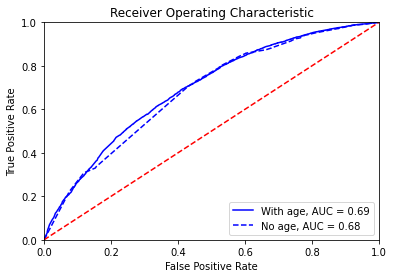

In [74]:
roc_auc_na = metrics.auc(fpr_na, tpr_na)
roc_auc_a = metrics.auc(fpr_a, tpr_a)


# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_a, tpr_a, 'b',label = 'With age, AUC = %0.2f' % roc_auc_a)
plt.plot(fpr_na, tpr_na, 'b--',label = 'No age, AUC = %0.2f' % roc_auc_na)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Data exploration

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

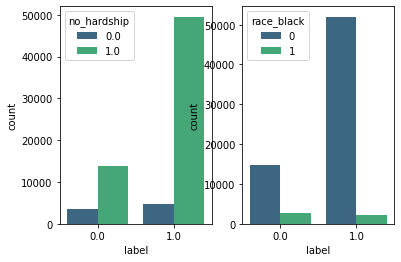

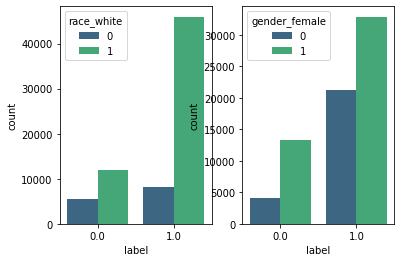

In [75]:
import seaborn as sns 
fig1, ax1 =plt.subplots(1,2)
sns.countplot('label',data=data,palette='viridis',hue='no_hardship',ax=ax1[0])
sns.countplot('label',data=data,palette='viridis',hue='race_black',ax=ax1[1])
fig1.show()

fig2, ax2 =plt.subplots(1,2)
sns.countplot('label',data=data,palette='viridis',hue='race_white',ax=ax2[0])
sns.countplot('label',data=data,palette='viridis',hue='gender_female',ax=ax2[1])
fig2.show()

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Confusion matrix of OLS
[[  764  4525]
 [  478 15713]]

Confusion matrix of Sigmoid
[[ 5289     0]
 [    0 16191]]


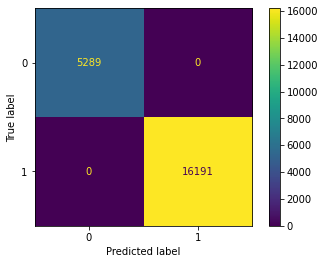

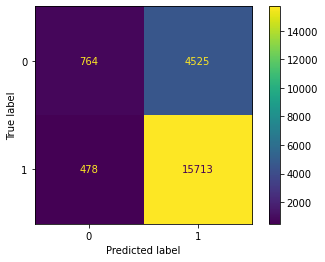

In [76]:
from statsmodels.formula.api import ols
from sklearn.metrics import confusion_matrix,r2_score
from sklearn.metrics import ConfusionMatrixDisplay

predictors = ['covid_death', 'withdrawn', 'distancing_stress', 'social_interaction', 'lack_companionship',
          'can_find_companionship', 'gen_health', 'gen_mental_health', 'gen_social_health',
          'gen_social_satisfac', 'no_home', 'no_meds', 'no_food', 'no_gas', 'no_rent', 'no_hardship',
          'family_conflict', 'family_yelling', 'friend_conflict', 'no_conflict', 'age', 'race_asian',
          'race_black', 'race_multiple', 'race_other', 'race_white', 'ethn_hispanic', 'ethn_none_of_these',
          'ethn_not_hispanic', 'sex_female', 'sex_male', 'gender_female', 'gender_male']


X_train, X_test, y_train, y_test = train_test_split(data[predictors],data['label'], test_size=0.3, random_state=44)
full_train = X_train
full_train['label'] = y_train
full_test = X_test
full_test['label'] = y_test

model_ols = ols('label~covid_death+withdrawn+distancing_stress+social_interaction+\
lack_companionship+can_find_companionship+gen_health+gen_mental_health+gen_social_health+\
gen_social_satisfac+no_home+no_meds+no_food+no_gas+no_rent+no_hardship+family_conflict+\
family_yelling+friend_conflict+no_conflict+age+race_asian+race_black+race_multiple+race_other+\
race_white+ethn_hispanic+ethn_none_of_these+ethn_not_hispanic+sex_male+gender_male',data=full_train).fit()


sigmoid_model = LogisticRegression().fit(X_train,y_train)
sigmoid_model.score(X_test,y_test)

pred_ols = model_ols.predict(X_test)
pred_sigmoid = sigmoid_model.predict_proba(X_test)
pred_sigmoid_class = sigmoid_model.predict(X_test)
pred_sigmoid = pred_sigmoid[:,1]


model_predictions = pd.DataFrame(columns = ['OLS_PRED','sigmoid_prob_PRED','sigmoid_class_PRED','actual'])
model_predictions['OLS_PRED'] = pred_ols
model_predictions['sigmoid_prob_PRED'] = pred_sigmoid
model_predictions['sigmoid_class_PRED'] = pred_sigmoid_class
model_predictions['actual'] = y_test

def class_pred(pred,cut_off):
    class_prediction=[]
    for i in pred:
        if i>=cut_off:
            class_prediction.append(1)
        else:
            class_prediction.append(0)
    return class_prediction

pred_ols_class=class_pred(model_predictions['OLS_PRED'],0.5)
model_predictions['ols_class_pred'] = pred_ols_class

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# A confusion matrix is a good indicator to show the accuracy of the model. The C0,0 is true negative(TN), C1,0 is false negative(FN)
#C1,1 is true positive (TP), and C0,1 is false positive( FP)
ols_conf_matrix = confusion_matrix(model_predictions['actual'],model_predictions['ols_class_pred'])
sigmoid_conf_matrix = confusion_matrix(model_predictions['actual'],model_predictions['sigmoid_class_PRED'])
print(f"Confusion matrix of OLS\n{ols_conf_matrix}\
\n\nConfusion matrix of Sigmoid\n{sigmoid_conf_matrix}")

disp1 = ConfusionMatrixDisplay(sigmoid_conf_matrix)
disp1.plot();

disp2 = ConfusionMatrixDisplay(ols_conf_matrix)
disp2.plot();

In [42]:


data['social_interaction']

# all our variables
predictors = ['covid_death', 'withdrawn', 'distancing_stress', 'social_interaction', 'lack_companionship',
          'can_find_companionship', 'gen_health', 'gen_mental_health', 'gen_social_health',
          'gen_social_satisfac', 'no_home', 'no_meds', 'no_food', 'no_gas', 'no_rent', 'no_hardship',
          'family_conflict', 'family_yelling', 'friend_conflict', 'no_conflict', 'age', 'race_asian',
          'race_black', 'race_multiple', 'race_other', 'race_white', 'ethn_hispanic', 'ethn_none_of_these',
          'ethn_not_hispanic', 'sex_female', 'sex_male', 'gender_female', 'gender_male']
X = data[predictors]
y=data['label']



type(X)


cohort=data.dropna(axis=1)

#cohort[].head(5)

cohort['gen_mental_health'].describe()

data['covid_death'].describe()

data['covid_death'].value_counts()


#data.head(5)

0.0    51625
1.0    19975
Name: covid_death, dtype: int64

In [41]:
data['label'].value_counts()

1.0    54225
0.0    17375
Name: label, dtype: int64

In [125]:
#TABLE 1 DESCRIPTIVE TABLE 
#note: I created these tables (briana), however, I am unsure how to change the labels of 0 and 1. Anyone have any ideas?

#cohort.rename(columns={'label':'VaccineHesitancy'})

#cohort.rename(columns={"label": "VaccineHesitancy"})

#print(cohort['VaccineHesitancy'])
#cohort['label'].value_counts()

demographic_var=['race_white', 'race_asian','race_black', 'race_multiple', 'race_other',  'ethn_hispanic', 'ethn_none_of_these', 'ethn_not_hispanic', 'gender_female', 'gender_male', 'age']
categorical_var=['race_white', 'race_asian','race_black', 'race_multiple', 'race_other',  'ethn_hispanic', 'ethn_none_of_these', 'ethn_not_hispanic', 'gender_female', 'gender_male']

labels_var={'race_white':'Race - White', 'race_asian':'Race - Asian','race_black':'Race - Black', 'race_multiple': 'Race - Multiple Races', 'race_other':'Race - Other',  'ethn_hispanic':'Ethnicity - Hispanic', 'ethn_none_of_these':'Ethnicity - None', 'ethn_not_hispanic': 'Ethnicity - Non-Hispanic', 'gender_female': 'Female', 'gender_male': 'Male', 'age':'Age'}
labels=['Race - Asian', 'Race - Black', 'Race - Multiple', 'Race - Other', 'Race - Other', 'Race - Other', 'Race - Other', 'Race - Other', 'Race - Other', 'Race - Other']
table1=TableOne(cohort, columns=demographic_var, categorical=categorical_var, nonnormal='age', groupby='label', missing=False,
                dip_test=True, normal_test=True, rename=labels_var, tukey_test=True, pval=True, pval_test_name=True)
print(table1)


#TableOne?


/home/jupyter/notebooks/packages/tableone/tableone.py:237: DeprecationWarning: The pval_test_name argument is deprecated; use htest_name instead.
  "htest_name instead.", DeprecationWarning)


                                   Grouped by label                                                            
                                            Overall               0.0               1.0 P-Value            Test
n                                             71600             17375             54225                        
Race - White, n (%)             0      13735 (19.2)       5459 (31.4)       8276 (15.3)  <0.001     Chi-squared
                                1      57865 (80.8)      11916 (68.6)      45949 (84.7)                        
Race - Asian, n (%)             0      69812 (97.5)      17053 (98.1)      52759 (97.3)  <0.001     Chi-squared
                                1        1788 (2.5)         322 (1.9)        1466 (2.7)                        
Race - Black, n (%)             0      66674 (93.1)      14678 (84.5)      51996 (95.9)  <0.001     Chi-squared
                                1        4926 (6.9)       2697 (15.5)        2229 (4.1)                 

# Start HERE to download data
## Run everything below 

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import os
from datetime import date
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import itertools
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import stats

try:
    from tableone import TableOne, load_dataset
except (ModuleNotFoundError, ImportError):
    # install on Colab
    !pip install tableone
    from tableone import TableOne, load_dataset

'try:\n    from tableone import TableOne, load_dataset\nexcept (ModuleNotFoundError, ImportError):\n    # install on Colab\n    !pip install tableone\n    from tableone import TableOne, load_dataset'

In [3]:
# read in the csv
data_filename = 'data.csv'
my_bucket = os.getenv('WORKSPACE_BUCKET')

os.system(f"gsutil cp '{my_bucket}/data/{data_filename}' .")
print(f'[INFO] {data_filename} is successfully downloaded into your working space')

# This is the data to work with
data = pd.read_csv('data.csv')


Copying gs://fc-secure-b41a20d8-cc27-4b00-94b8-ccd4711ca733/data/data.csv...
/ [1 files][ 17.0 MiB/ 17.0 MiB]                                                
Operation completed over 1 objects/17.0 MiB.                                     


[INFO] data.csv is successfully downloaded into your working space
